In [2]:
import pandas as pd

df = pd.read_csv('./network_backup_dataset.csv')
df_group = df.groupby([df.columns[0], df.columns[1], df.columns[3]], sort=False).sum().iloc[:,1:2]

In [3]:
sizes = [[],[],[],[],[]]
length=0
for index, row in df_group.iterrows():
    sizes[int(index[2][-1])].append(row[0])

In [23]:
import csv
from collections import defaultdict

# Key: 
# Week # 
# Day of Week 
# Backup Start Time - Hour of Day 
# Work-Flow-ID : work_flow_0 ... work_flow_4
# File Name
# Size of Backup (GB)
# Backup Time (hour)

datareader = csv.DictReader(open('network_backup_dataset.csv', 'r'), delimiter=',')

current_day = 0 # Track the day of week
file_sizes = defaultdict(list) # Record file sizes for each work flow ID

for row in datareader:
    if row['Day of Week'] != current_day: # New day
        current_day = row['Day of Week']
        for i in range(5):
            file_sizes[i].append(0)
        file_sizes[int(row['Work-Flow-ID'][-1])][-1] += float(row['Size of Backup (GB)'])
    else: # Same day
        file_sizes[int(row['Work-Flow-ID'][-1])][-1] += float(row['Size of Backup (GB)'])

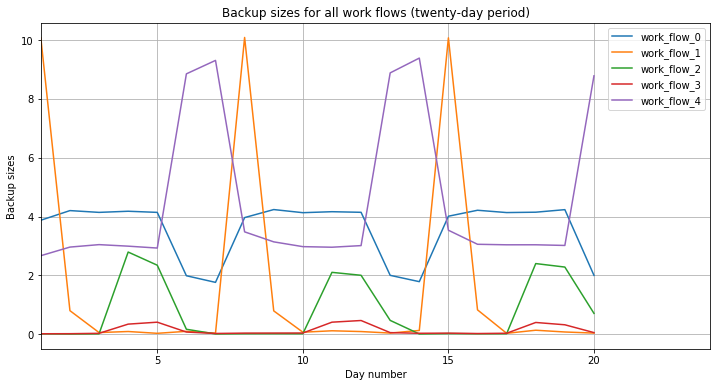

In [26]:
import matplotlib.pyplot as plt

# Plot 20 days
plt.figure(figsize=(12, 6))
plt.title("Backup sizes for all work flows (twenty-day period)")
for i in range(5):
    plt.plot(range(1, 21),file_sizes[i][0:20], label=('work_flow_%d' % i))
plt.xlabel('Day number')
plt.ylabel('Backup sizes')
plt.xlim(1, 24)
plt.legend()
plt.grid()
plt.savefig('./Question1_a.png')  # Save the figure
plt.show()



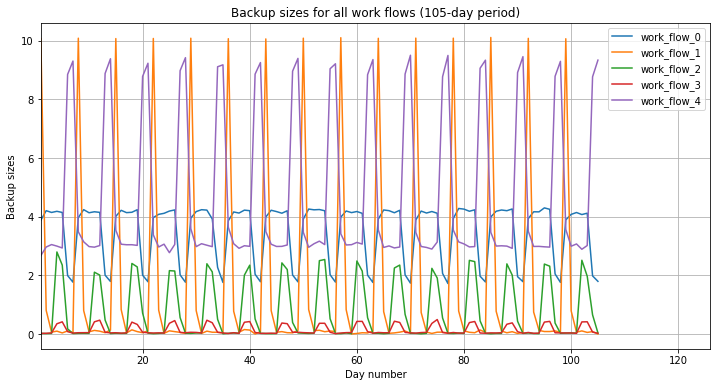

In [27]:
import matplotlib.pyplot as plt

# Plot 105 days
plt.figure(figsize=(12, 6))
plt.title("Backup sizes for all work flows (105-day period)")
for i in range(5):
    plt.plot(range(1, 106),file_sizes[i][0:106], label=('work_flow_%d' % i))
plt.xlabel('Day number')
plt.ylabel('Backup sizes')
plt.xlim(1, 126)
plt.legend()
plt.grid()
plt.savefig('./Question1_b.png')  # Save the figure
plt.show()


Question2

In [105]:
filename = 'network_backup_dataset.csv'

#headers = ['Week #', 'Day of Week', 'Backup Start Time', 'Hour of Day', 
#           'Work-Flow-ID', 'File Name', 'Size of Backup (GB)', 'Backup Time (hour)']

#original data 
data = pd.read_csv(filename)
data.drop('Backup Time (hour)', axis = 1, inplace = True)
pre_gt = data['Size of Backup (GB)']
data.drop('Size of Backup (GB)', axis = 1, inplace = True)

In [106]:
scaler_enc_data = data # scaler encoding data
print(set(scaler_enc_data['Week #']))
print(set(scaler_enc_data['Backup Start Time - Hour of Day']))
print(set(scaler_enc_data['Day of Week']))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{1, 5, 9, 13, 17, 21}
{'Tuesday', 'Sunday', 'Monday', 'Saturday', 'Friday', 'Thursday', 'Wednesday'}


In [107]:
def scaler_encoding(): # 
    encoding_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
    for row in range(len(scaler_enc_data)):
        # encode 'Day of Week'
        #print(need_enc_data.columns)
        scaler_enc_data.loc[row,'Day of Week'] = encoding_map[scaler_enc_data.loc[row,'Day of Week']]
        # encode 'Work-Flow-ID'
        scaler_enc_data.loc[row,'Work-Flow-ID'] = int(scaler_enc_data.loc[row,'Work-Flow-ID'][-1])
        # encode 'File Name'
        scaler_enc_data.loc[row, 'File Name'] = int(scaler_enc_data.loc[row, 'File Name'][5:])
    #return need_enc_data    

scaler_encoding()
print(scaler_enc_data.head(5))

   Week #  Day of Week  Backup Start Time - Hour of Day  Work-Flow-ID  \
0       1            1                                1             0   
1       1            1                                1             2   
2       1            1                                1             2   
3       1            1                                1             2   
4       1            1                                1             2   

   File Name  
0          0  
1         12  
2         13  
3         14  
4         16  


In [108]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from math import sqrt
from sklearn.linear_model import Ridge


#allpre_res = [None for i in range(len(data))]
def model_building(dataset, allpre_res): 
    train_RMSE = []
    test_RMSE = []
    #kf = KFold(n_splits = 10, random_state = None, shuffle = True)
    kf = KFold(n_splits = 10, random_state = None, shuffle = False)
    # Create linear regression object
    regr = linear_model.LinearRegression()
    for train_index, test_index in kf.split(dataset):

        X_train, X_test = dataset[train_index], dataset[test_index]
        y_train, y_test = pre_gt[train_index], pre_gt[test_index]
        #print(type(y_train))
            
        # Train the model using the training sets
        regr.fit(X_train, y_train)
        # Make predictions using the training set
        train_pred_y = regr.predict(X_train)
        # Make predictions using the testing set
        test_pred_y = regr.predict(X_test)
        
        for i in range(len(test_index)):
            allpre_res[test_index[i]] = test_pred_y[i]

   
        # RMSE in train set
        train_RMSE.append(mean_squared_error(y_train, train_pred_y))
        # RMSE in test set
        test_RMSE.append(mean_squared_error(y_test, test_pred_y))
    print("the last fold of coefficients are: \n", regr.coef_)
    print("training RMSE: %lf" %sqrt(np.mean(train_RMSE)), "testing RMSE: %lf" %sqrt(np.mean(test_RMSE)))
    return sqrt(np.mean(train_RMSE)), sqrt(np.mean(test_RMSE))  

    
def two_plots(allpre_res, pre_gt):
    x = np.arange(0, 1000)
    y1 = allpre_res 
    y2 = pre_gt  
    residual = pre_gt - allpre_res
    y3 = residual

    # show basic model plot
    # fitted value & ground truth
    # only plot the first 1000 data points and results we get.
    # blue 'x' is gt, while red 'x' is fitted value
    fig = plt.figure()  
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y2[0:1000], 'bx', label='ground truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

    # fitted value & residual
    fig = plt.figure()  
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y3[0:1000], 'bx', label='residual')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()    



the last fold of coefficients are: 
 [-4.47872791e-05 -2.48582064e-03  1.39000106e-03  2.04745046e-03
 -3.05163680e-07]
training RMSE: 0.103585 testing RMSE: 0.103676


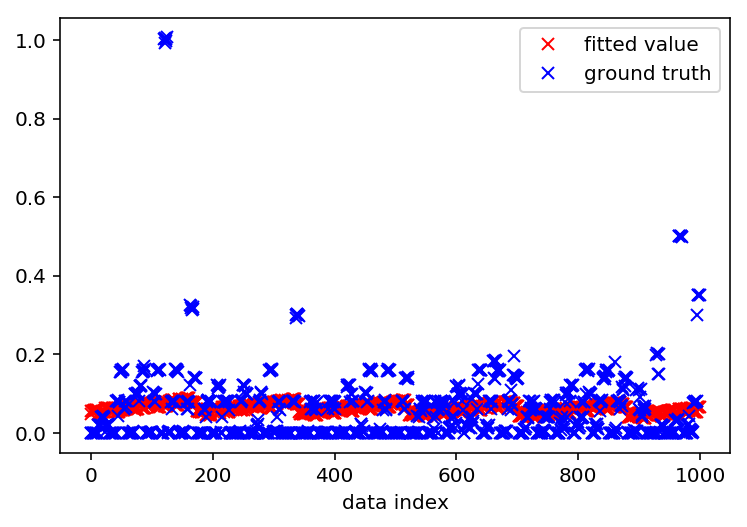

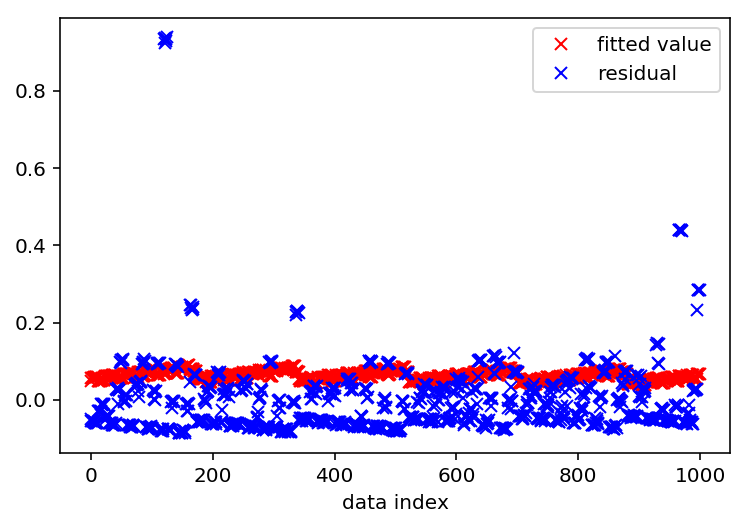

In [109]:
# basic linear model -- results and plots
allpre_res = [None for i in range(len(data))]
model_building(scaler_enc_data.values,allpre_res)
#print(allpre_res)
two_plots(allpre_res, pre_gt)

question 2(b)

In [110]:
import warnings
warnings.filterwarnings("ignore")

In [111]:
import pandas as pd

df = pd.read_csv('./network_backup_dataset.csv')
df_group = df.groupby([df.columns[0], df.columns[1], df.columns[3]], sort=False).sum().iloc[:,1:2]

In [112]:
import calendar
days = dict(zip(calendar.day_name,range(1,8)))

df.drop('Backup Time (hour)', axis=1, inplace=True)
df['Day of Week'] = df['Day of Week'].apply(lambda s: days[s])

f = lambda s: int(s[s.rindex('_')+1:])

df['Work-Flow-ID'] = df['Work-Flow-ID'].apply(f)
df['File Name'] = df['File Name'].apply(f)

In [113]:
Xs = df.ix[:, [0, 1, 2, 3, 4]].values
ys = df.ix[:, 5].values


In [114]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
def cv_random_forest(model, X, y):
    kf = KFold(n_splits=10)
    rmse_train, rmse_test = 0, 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        rmse_train += mean_squared_error(y_train, model.predict(X_train))
        rmse_test += mean_squared_error(y_test, model.predict(X_test))

    return sqrt(rmse_train / 10), sqrt(rmse_test / 10)

In [115]:
# Question 2b (i)
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=4, bootstrap=True, oob_score=True)
rmse_train, rmse_test = cv_random_forest(regr, Xs, ys)
print ("Training RMSE:", rmse_train)
print ("Testing RMSE:", rmse_test)
print ("oob score:", regr.oob_score_)

Training RMSE: 0.06069041002548773
Testing RMSE: 0.06076664492736625
oob score: 0.6515227275747644


In [116]:
import plotly.offline as py
import plotly.graph_objs as go
def draw_curve(x, y, name, title='', xlabel='', ylabel=''):
    data = []
    width, height = 800, 600
    
    if type(name) != list or len(name) == 1:
        width, height = 600, 450
        trace1 = go.Scatter(x=x, y=y, 
                            mode='lines', 
                            line=dict(color='darkorange', width=2),
                            name=name
                           )
        data.append(trace1)
    else:
        for i in range(len(name)):
            trace1 = go.Scatter(x=x[i], y=y[i], 
                                mode='lines', 
                                line=dict(width=2),
                                name=name[i]
                               )
            data.append(trace1)
    
    layout = go.Layout(title=title,
                       autosize=False,
                       width=width,
                       height=height,
                       xaxis=dict(title=xlabel, ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title=ylabel, ticks='outside', mirror=True, linewidth=1),
                       legend=dict(x=.5, y=.2, bordercolor='#D3D3D3', borderwidth=1))
    
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [117]:
# Question 2b (ii)
import matplotlib.pyplot as plt
oob_scores_features = []
rmse_tests_features = []
featureRange = range(1, 6)
numTreeRange = range(1, 201)
for maxNumFeatures in featureRange:
    oob_scores = []
    rmse_tests = []
    for numTree in numTreeRange:
        regr = RandomForestRegressor(n_estimators=numTree, max_features=maxNumFeatures, max_depth=4, bootstrap=True, oob_score=True)
        rmse_train, rmse_test = cv_random_forest(regr, Xs, ys)
        oob_scores.append(regr.oob_score_)
        rmse_tests.append(rmse_test)
    print ("Progress at max feature = %d" % maxNumFeatures)
    oob_scores_features.append(oob_scores)
    rmse_tests_features.append(rmse_tests)
oob_scores_names = ['max number of features = %d' % x for x in featureRange]

Progress at max feature = 1
Progress at max feature = 2
Progress at max feature = 3
Progress at max feature = 4
Progress at max feature = 5


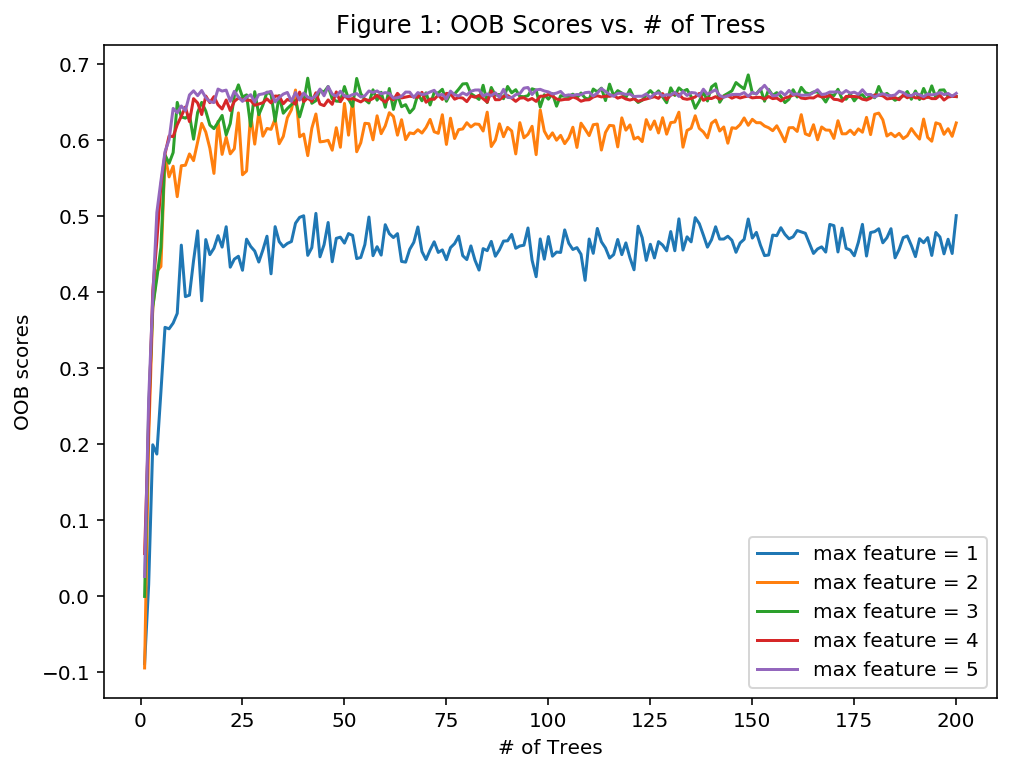

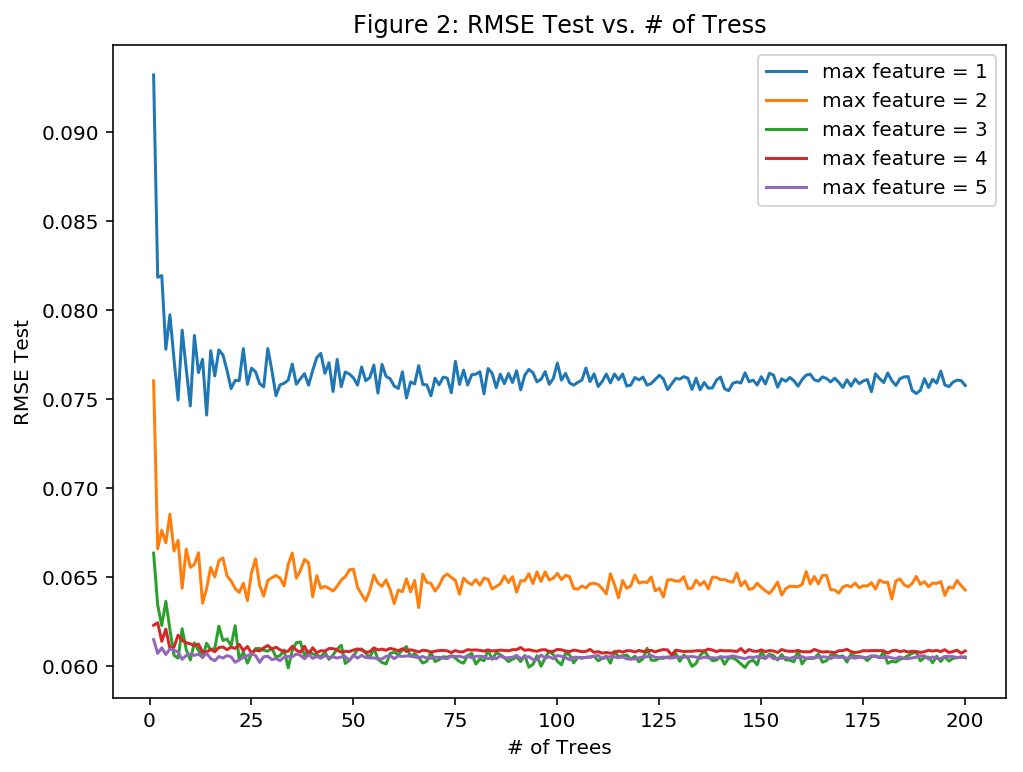

In [118]:
plt.figure(figsize=(8,6))
plt.plot(numTreeRange, oob_scores_features[0], numTreeRange, oob_scores_features[1], numTreeRange, oob_scores_features[2],numTreeRange, oob_scores_features[3],numTreeRange, oob_scores_features[4])
plt.legend(['max feature = 1', 'max feature = 2', 'max feature = 3', 'max feature = 4', 'max feature = 5'], loc='lower right')
plt.xlabel('# of Trees')
plt.ylabel('OOB scores')
plt.title('Figure 1: OOB Scores vs. # of Tress')
plt.show()
plt.figure(figsize=(8,6))
plt.plot(numTreeRange, rmse_tests_features[0], numTreeRange, rmse_tests_features[1], numTreeRange, rmse_tests_features[2],numTreeRange, rmse_tests_features[3],numTreeRange, rmse_tests_features[4])
plt.legend(['max feature = 1', 'max feature = 2', 'max feature = 3', 'max feature = 4', 'max feature = 5'], loc='top right')
plt.xlabel('# of Trees')
plt.ylabel('RMSE Test')
plt.title('Figure 2: RMSE Test vs. # of Tress')
plt.show()

In [119]:
max_oob_score, max_oob_score_index = max((x, (i, j)) for i, row in enumerate(oob_scores_features) for j, x in enumerate(row))
print (max_oob_score, "at max feature =", max_oob_score_index[0] + 1, "and # of Trees =", max_oob_score_index[1] + 1)

0.6859839618615451 at max feature = 3 and # of Trees = 149


In [120]:
min_RMSE, min_RMSE_index = min((x, (i, j)) for i, row in enumerate(rmse_tests_features) for j, x in enumerate(row))
print(min_RMSE, "at max feature =", min_RMSE_index[0] + 1, "and # of Trees =", min_RMSE_index[1] + 1)

0.059910642274289556 at max feature = 3 and # of Trees = 34


In [121]:
best_max_feature = 3
best_num_tree_range = range(10, 101)
oob_scores_depth = []
rmse_tests_depth = []
tree_depth = range(10, 16)
for depth in tree_depth:
    oob_scores = []
    rmse_tests = []
    for numTree in best_num_tree_range:
            regr = RandomForestRegressor(n_estimators=numTree, max_features=best_max_feature, max_depth=depth, bootstrap=True, oob_score=True)
            rmse_train, rmse_test = cv_random_forest(regr, Xs, ys)
            oob_scores.append(regr.oob_score_)
            rmse_tests.append(rmse_test)
    oob_scores_depth.append(oob_scores)
    rmse_tests_depth.append(rmse_tests)
    print ("Progress at tree depth = %d" % depth)

Progress at tree depth = 10
Progress at tree depth = 11
Progress at tree depth = 12
Progress at tree depth = 13
Progress at tree depth = 14
Progress at tree depth = 15


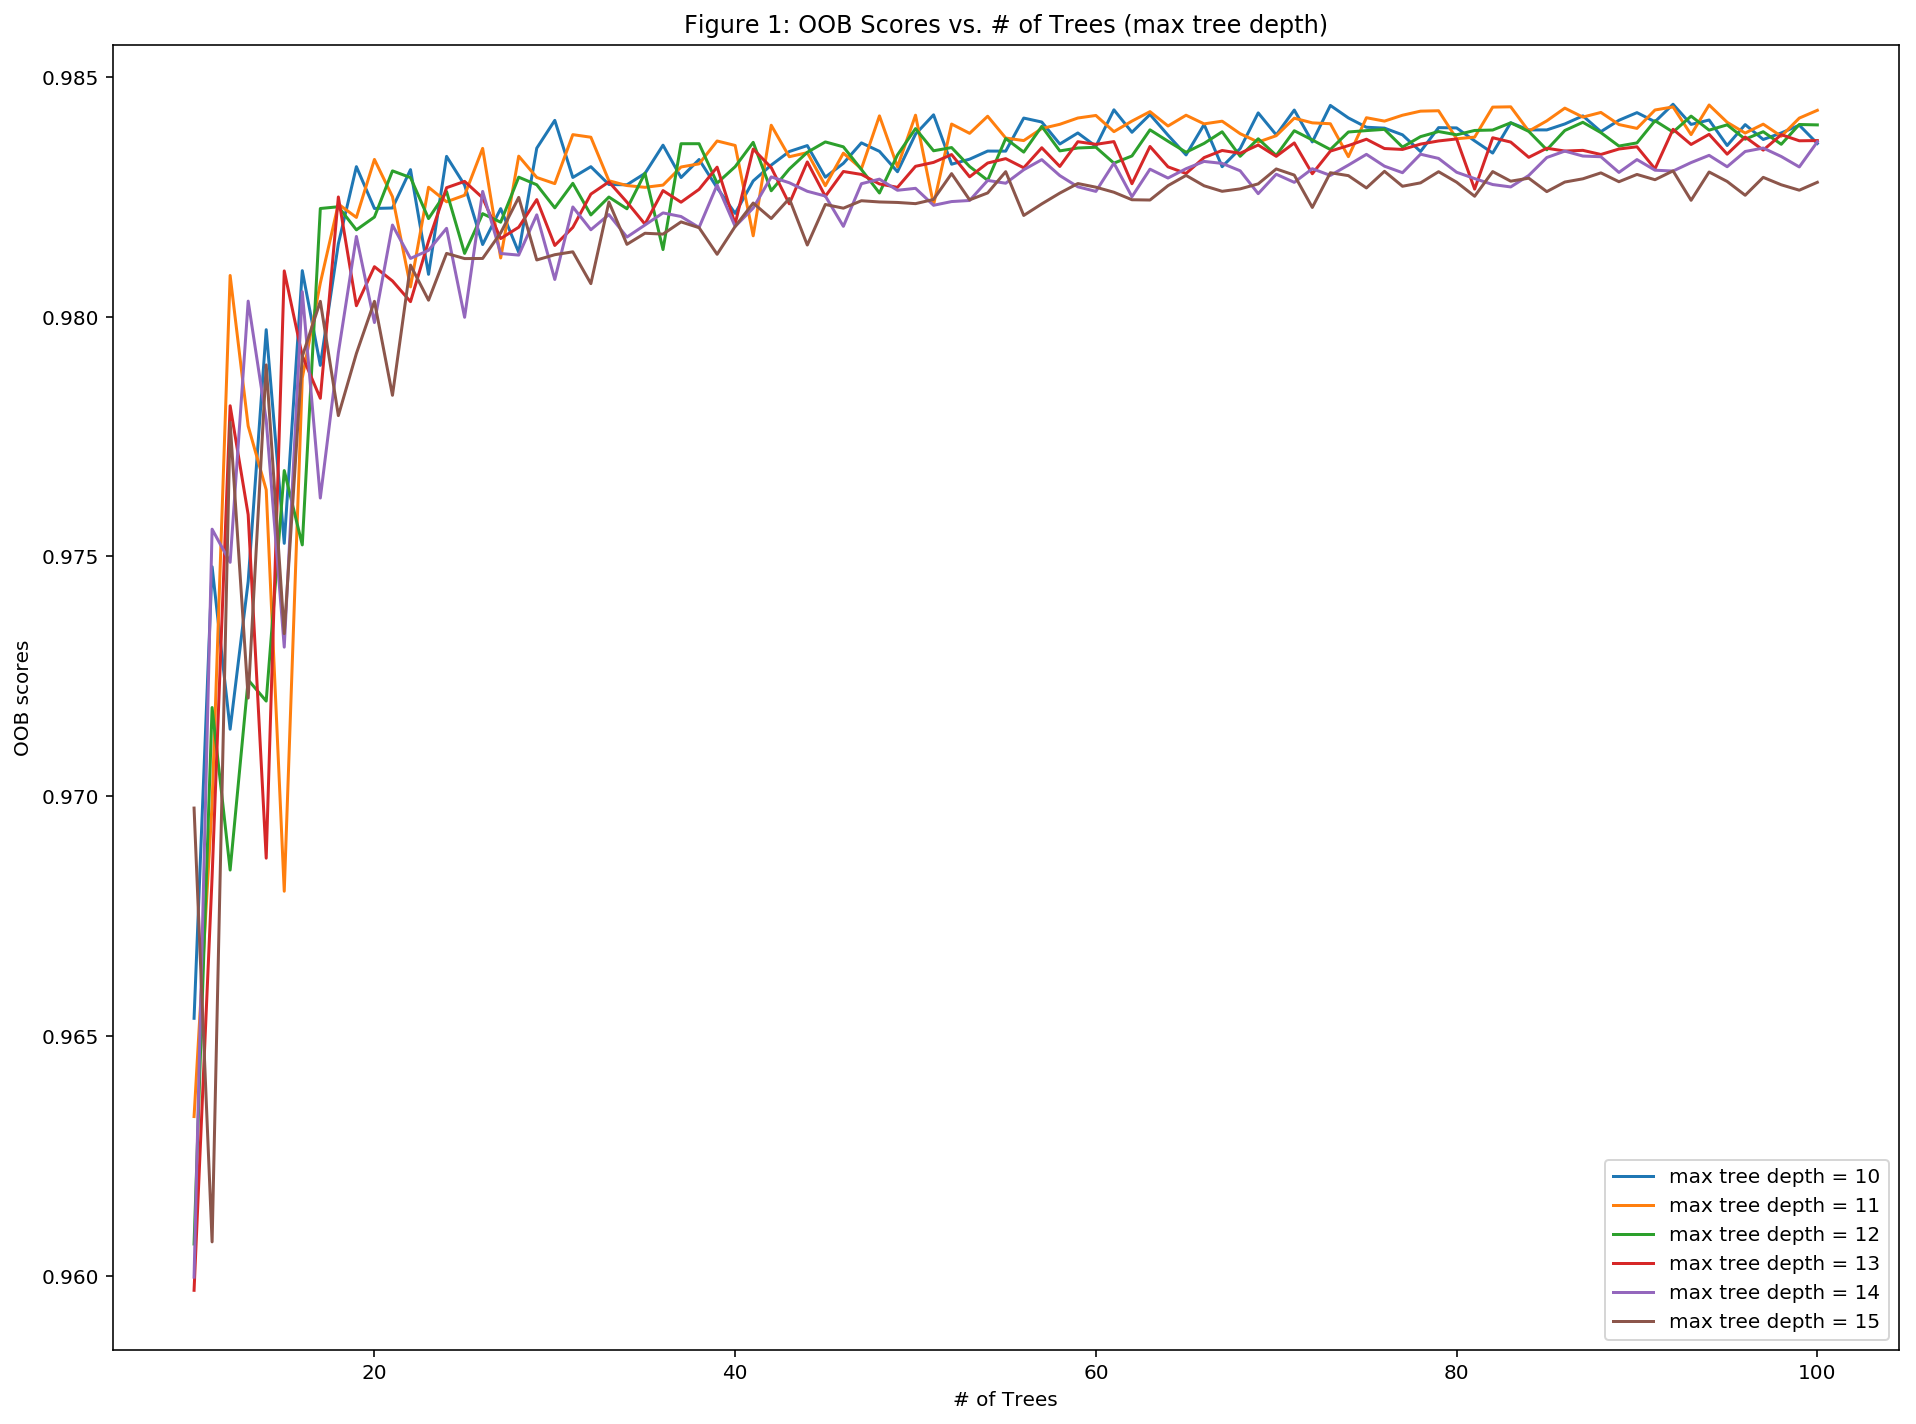

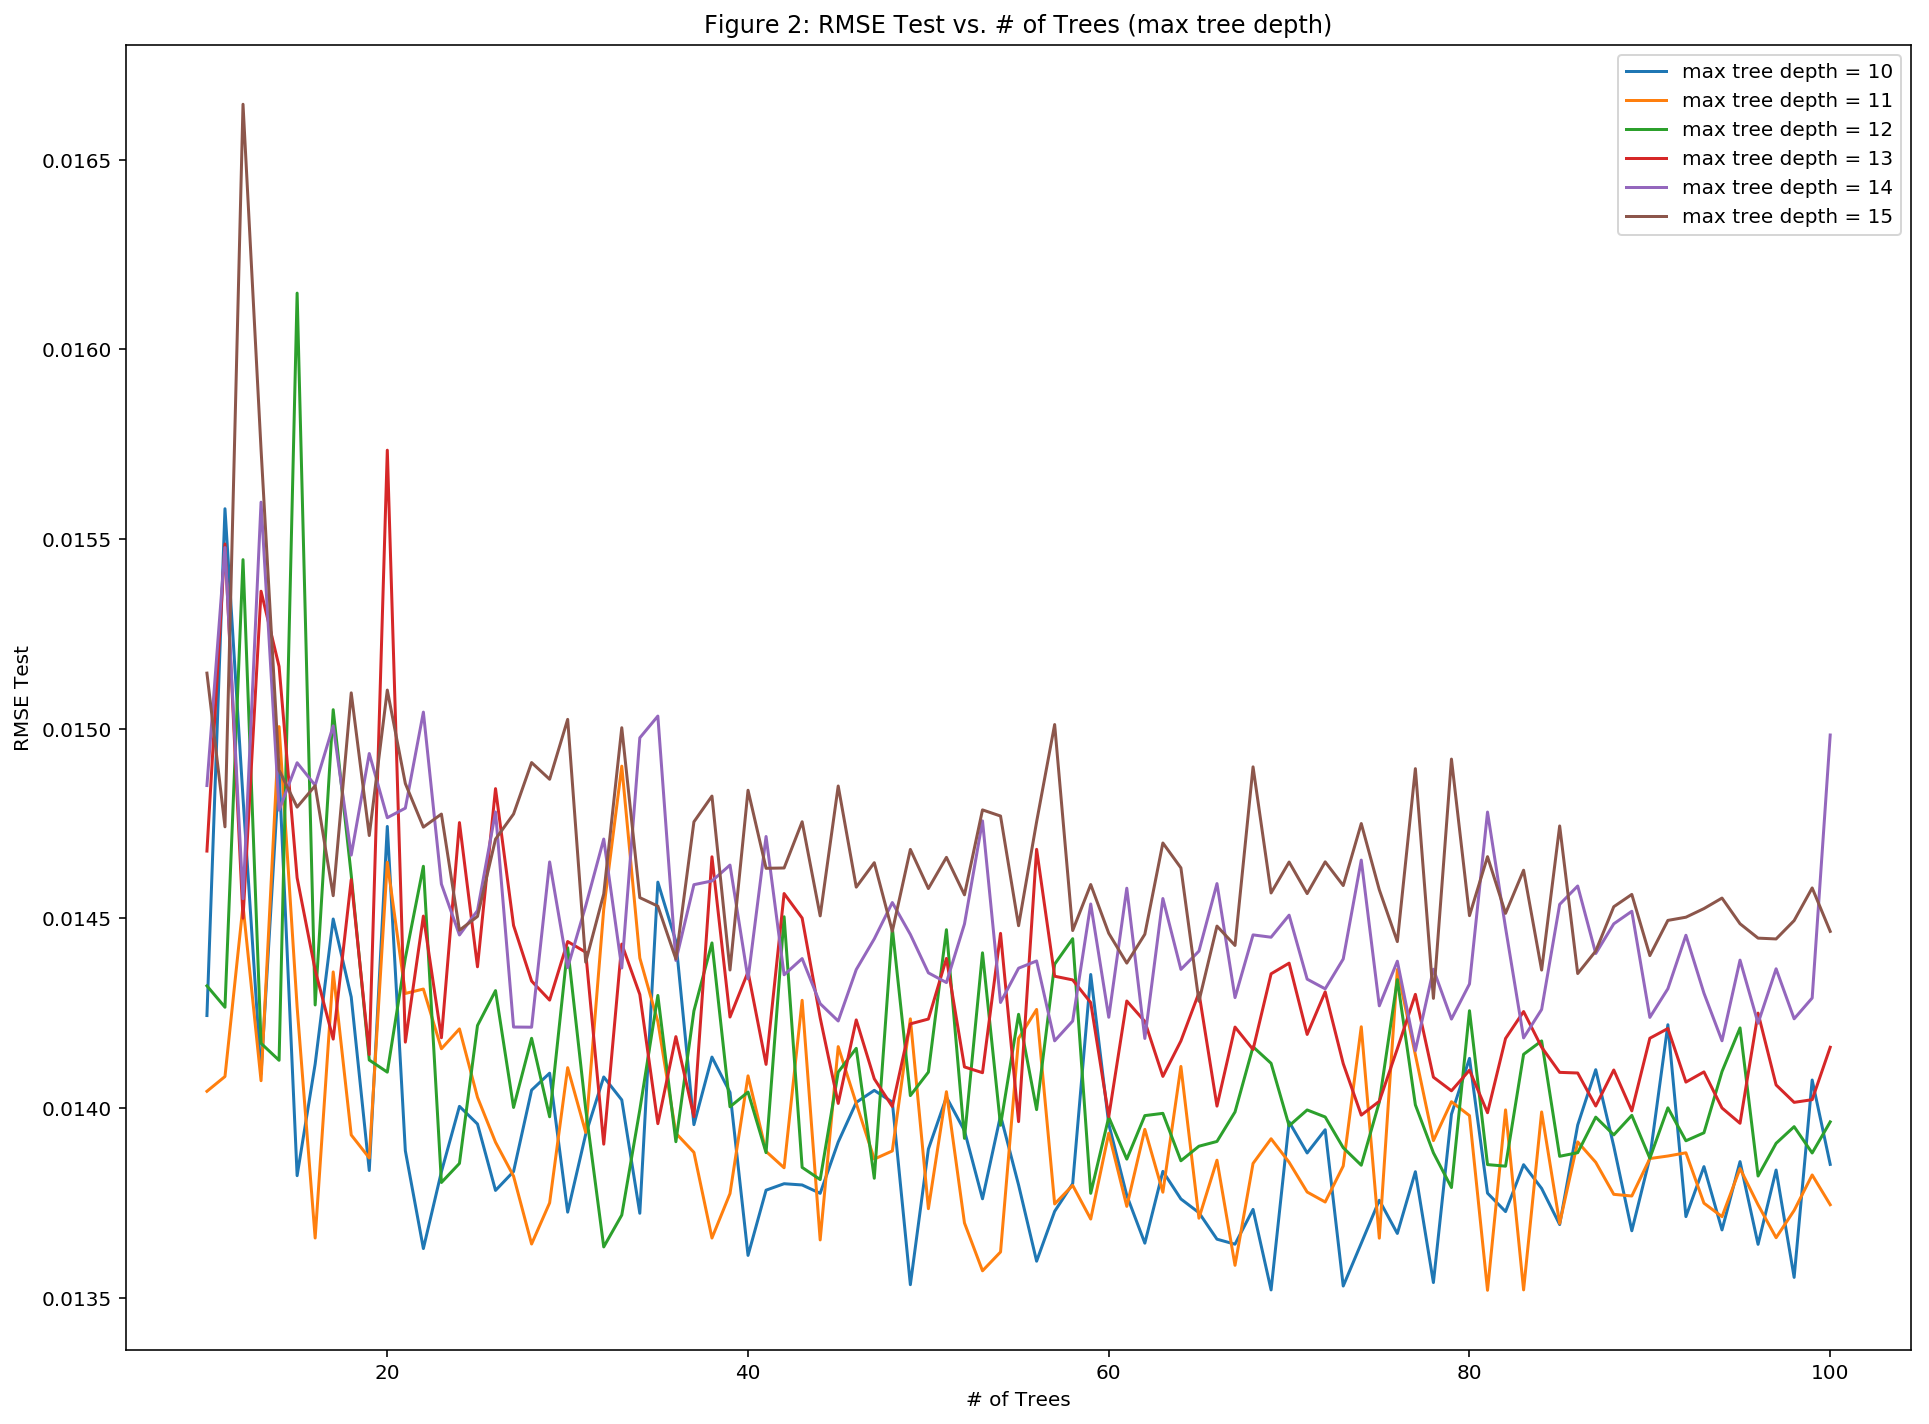

In [122]:
plt.figure(figsize=(16,12))
plt.plot(best_num_tree_range, oob_scores_depth[0], best_num_tree_range, oob_scores_depth[1], best_num_tree_range, oob_scores_depth[2],best_num_tree_range, oob_scores_depth[3],best_num_tree_range, oob_scores_depth[4], best_num_tree_range, oob_scores_depth[5])
plt.legend(['max tree depth = 10', 'max tree depth = 11', 'max tree depth = 12', 'max tree depth = 13', 'max tree depth = 14', 'max tree depth = 15'], loc='lower right')
plt.xlabel('# of Trees')
plt.ylabel('OOB scores')
plt.title('Figure 1: OOB Scores vs. # of Trees (max tree depth)')
plt.show()
plt.figure(figsize=(16,12))
plt.plot(best_num_tree_range, rmse_tests_depth[0], best_num_tree_range, rmse_tests_depth[1], best_num_tree_range, rmse_tests_depth[2],best_num_tree_range, rmse_tests_depth[3],best_num_tree_range, rmse_tests_depth[4], best_num_tree_range, rmse_tests_depth[5])
plt.legend(['max tree depth = 10', 'max tree depth = 11', 'max tree depth = 12', 'max tree depth = 13', 'max tree depth = 14', 'max tree depth = 15'], loc='top right')
plt.xlabel('# of Trees')
plt.ylabel('RMSE Test')
plt.title('Figure 2: RMSE Test vs. # of Trees (max tree depth)')
plt.show()

In [123]:
max_oob_score, max_oob_score_index = max((x, (i, j)) for i, row in enumerate(oob_scores_depth) for j, x in enumerate(row))
print (max_oob_score, "at max tree depth =", max_oob_score_index[0]+10, "and # of Trees =", max_oob_score_index[1] + 10)

0.98442970656926 at max tree depth = 10 and # of Trees = 92


In [124]:
min_RMSE, min_RMSE_index = max((x, (i, j)) for i, row in enumerate(rmse_tests_depth) for j, x in enumerate(row))
print (min_RMSE, "at max tree depth =", min_RMSE_index[0] + 10, "and # of Trees =", min_RMSE_index[1] + 10)

0.0166460144101052 at max tree depth = 15 and # of Trees = 12


In [125]:
best_num_tree = 90
best_max_feature = 3
best_max_depth = 15
bestRFModel = RandomForestRegressor(n_estimators=best_num_tree, max_features=best_max_feature, max_depth=best_max_depth, bootstrap=True, oob_score=True)
rmse_train, rmse_test = cv_random_forest(bestRFModel, Xs, ys)
print ("Test RMSE is", rmse_test)
print ("Feature importances:", bestRFModel.feature_importances_)

Test RMSE is 0.014438802408859043
Feature importances: [0.00899751 0.29747771 0.33773083 0.17266517 0.18312878]


In [126]:
from sklearn import tree
tree.export_graphviz(bestRFModel.estimators_[0], out_file='bestRF.dot', max_depth=4)

<Figure size 432x288 with 0 Axes>

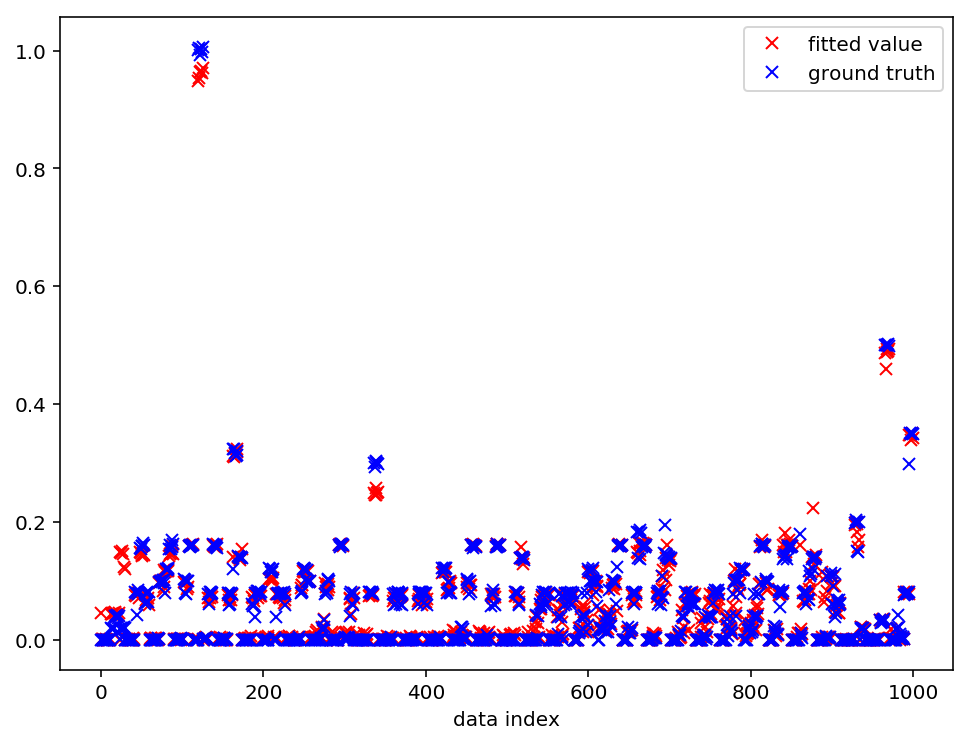

<Figure size 432x288 with 0 Axes>

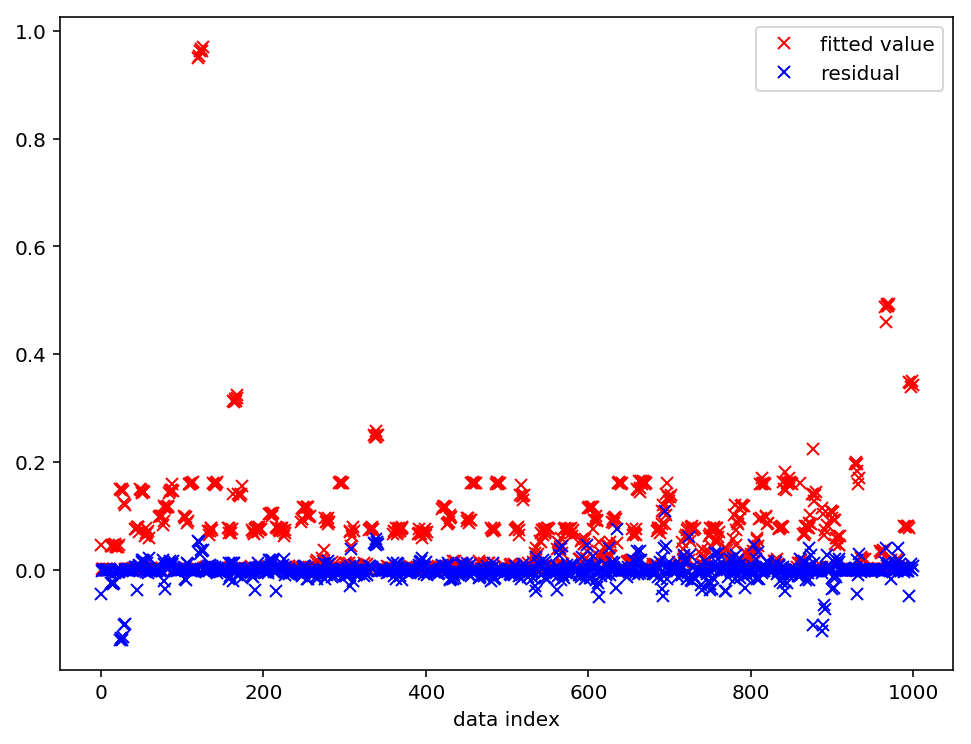

In [127]:
kf = KFold(n_splits=10)
allpre_res = [None for i in range(len(df))]
for train_index, test_index in kf.split(Xs):
    X_train, X_test = Xs[train_index], Xs[test_index]
    y_train, y_test = ys[train_index], ys[test_index]
    bestRFModel.fit(X_train, y_train)
    train_pred_y = bestRFModel.predict(X_train)
    test_pred_y = bestRFModel.predict(X_test)
    for i in range(len(test_index)):
        allpre_res[test_index[i]] = test_pred_y[i]

def two_plots(allpre_res, pre_gt):
    x = range(0, 1000)
    y1 = allpre_res 
    y2 = pre_gt  
    residual = pre_gt - allpre_res
    y3 = residual

    # show basic model plot
    # fitted value & ground truth
    # only plot the first 1000 data points and results we get.
    # blue 'x' is gt, while red 'x' is fitted value
    fig = plt.figure()
    plt.figure(figsize=(8,6))
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y2[0:1000], 'bx', label='ground truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

    # fitted value & residual
    fig = plt.figure()
    plt.figure(figsize=(8,6))
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y3[0:1000], 'bx', label='residual')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

two_plots(allpre_res, ys)

question 2(c) Neural Network

In [128]:
import warnings
warnings.filterwarnings("ignore")

In [129]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# one hot encoding
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

py.init_notebook_mode(connected=True)

features = ['Week', 'DayOfWeek','BackupStartTime', 'WorkFlowID', 'Filename','SizeOfBackup','BackupTime']
weekdays = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df = pd.read_csv('./network_backup_dataset.csv', names = features, header = 0)
df.drop(6)
training_label = np.asarray(df['SizeOfBackup'].values, dtype=np.float)

def encode_day_names(days):
    res = []
    for day in days:
        res.append(weekdays[day])
    return res

def encode_files(files):
    res = []
    for file in files:
        a,b = file.split('_')
        res.append(int(b))
    return res

def encode_work_flows(work_flows):
    res = []
    for wf in work_flows:
        a,b,c = wf.split('_')
        res.append(int(c))
    return res

X = df.ix[:, [0, 1, 2, 3, 4]].values
X[:, 1] = encode_day_names(X[:, 1])
X[:, 3] = encode_work_flows(X[:, 3])
X[:, 4] = encode_files(X[:, 4])



In [130]:
training_data = pd.DataFrame(X).astype('float64')
onehot_encoded_data = []
label_encoder = LabelEncoder()
integer_encoded = training_data.apply(label_encoder.fit_transform)
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded_data = onehot_encoder.fit_transform(integer_encoded)
scaler = StandardScaler()
standard_data = scaler.fit_transform(onehot_encoded_data)

Plot the fitted values against true values and residual values

In [131]:
def two_plots_revised(allpre_res, pre_gt):
    x = np.arange(0, 1000)
    y1 = allpre_res
    y2 = pre_gt
    residual = []
    for i in range(0, len(allpre_res)):
        residual.append(allpre_res[i]-pre_gt[i])
    # residual = pre_gt - allpre_res
    y3 = residual

    # show basic model plot
    # fitted value & ground truth
    # only plot the first 1000 data points and results we get.
    # blue 'x' is gt, while red 'x' is fitted value
    fig = plt.figure()
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y2[0:1000], 'bx', label='ground truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

    # fitted value & residual
    fig = plt.figure()
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y3[0:1000], 'bx', label='residual')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

Build Model and sweep the parameters

In [133]:
# print onehot_encoded_data
# Number of hidden units
# Activity Function(relu, logistic, tanh)
activation = ['relu', 'logistic', 'tanh']
lineStyle = [dict(color='blue', dash = 'dash', width=2), dict(color=('rgb(255, 218, 0)'), dash = 'dash', width=2),dict(color=('rgb(177, 228, 0)'), width=2), dict(color=('rgb(91, 116, 0)'), width=2),
             dict(color=('rgb(81, 147, 245)'), dash='dot', width=2), dict(color=('rgb(158, 135, 176)'), dash = 'dot', width=2)]
folds = 10
rmse_train = []
rmse_test = []
rmse_plot_train = []
rmse_plot_test = []
plot_gd_all = []
plot_test_all = []
rmse_plots = []
data = []
k = 0
min_test = 100
min_act = ""
min_hidden = 0
x_data = np.arange(5,200,10)
for actfunc in activation:
    for layersize in range(5,200,10):
        for rd in range(folds):
            clf = MLPRegressor(hidden_layer_sizes=(layersize),activation=actfunc,solver='lbfgs',max_iter=100,learning_rate_init=0.01,alpha=0.01)
            X_train, X_test, y_train, y_test = train_test_split(standard_data, training_label, train_size=0.9)
            # pipeline = Pipeline([("polynomial_features", polynomial_features), ("Neural_network", clf)])
            pipeline = Pipeline([ ("Neural_network", clf)])
            pipeline.fit(X_train, y_train)
            train_predict = pipeline.predict(X_train)
            test_predict = pipeline.predict(X_test)
            # clf.fit(onehot_encoded_data, training_label)
            # print standard_data.shape
            # print training_label.shape
            rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
            rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predict)))
        print ('rmse_train: ', np.mean(rmse_train), 'rmse_test:', np.mean(rmse_test), 'layersize:', layersize, 'actfunc: ', actfunc)
        if min_test > np.mean(rmse_test):
            min_test = np.mean(rmse_test)
            min_hidden = layersize
            min_act = actfunc
        rmse_plot_train.append(np.mean(rmse_train))
        rmse_plot_test.append(np.mean(rmse_test))
        # rmse_plot_train.append(np.mean(rmse_train))
        # rmse_plot_test.append(np.mean(rmse_test))
        rmse_train = []
        rmse_test = []
    # plot_func(x_data, rmse_plot_test, '', actfunc, "Test")
    data.append(go.Scatter(x=x_data, y=rmse_plot_train, mode='lines', line=lineStyle[k],name="Train_"+actfunc))
    k+=1
    data.append(go.Scatter(x=x_data, y=rmse_plot_test, mode='lines', line=lineStyle[k], name="Test_" + actfunc))
    k+=1
    rmse_plot_train = []
    rmse_plot_test = []
print("min test rmse: ", min_test,"at hidden layer size: ", min_hidden,"at activity function: ", min_act)
layout = go.Layout(title="Train/Test-RMSE VS number of hidden units for different activity function",
                       autosize=False,
                       width=800,
                       height=600,
                       xaxis=dict(title="Hidden Layer Units", ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title="RMSE", ticks='outside', mirror=True, linewidth=1),legend=dict(x=-.1, y=1.2))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="")

rmse_train:  0.08241901138631041 rmse_test: 0.08100854903982599 layersize: 5 actfunc:  relu
rmse_train:  0.07886137362200853 rmse_test: 0.0791052621864267 layersize: 15 actfunc:  relu
rmse_train:  0.07961545771012332 rmse_test: 0.08216611582001497 layersize: 25 actfunc:  relu
rmse_train:  0.0766287919638857 rmse_test: 0.07809755625150688 layersize: 35 actfunc:  relu
rmse_train:  0.07212403648937517 rmse_test: 0.07692107830176144 layersize: 45 actfunc:  relu
rmse_train:  0.06790899655727124 rmse_test: 0.0694569681150748 layersize: 55 actfunc:  relu
rmse_train:  0.06548232796560068 rmse_test: 0.06596127923914687 layersize: 65 actfunc:  relu
rmse_train:  0.06468283418163742 rmse_test: 0.06336248178021978 layersize: 75 actfunc:  relu
rmse_train:  0.06272167416372784 rmse_test: 0.06410272143992443 layersize: 85 actfunc:  relu
rmse_train:  0.06153133930876302 rmse_test: 0.06545407519938524 layersize: 95 actfunc:  relu
rmse_train:  0.061002356169714965 rmse_test: 0.06324585713679412 layersize

plot

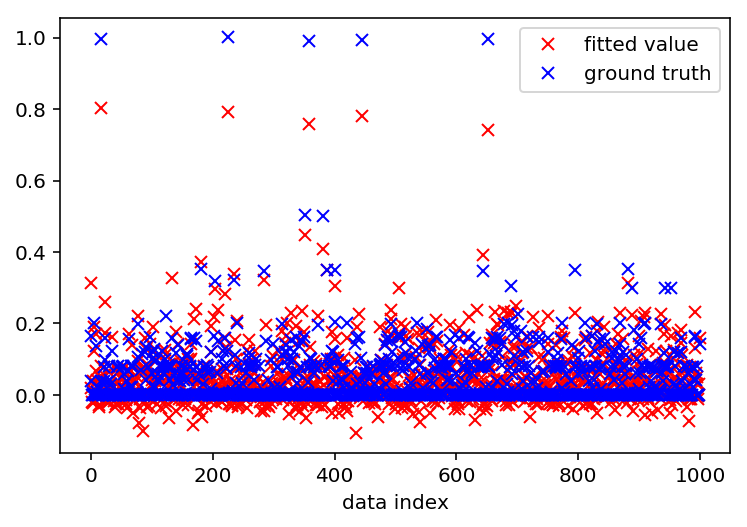

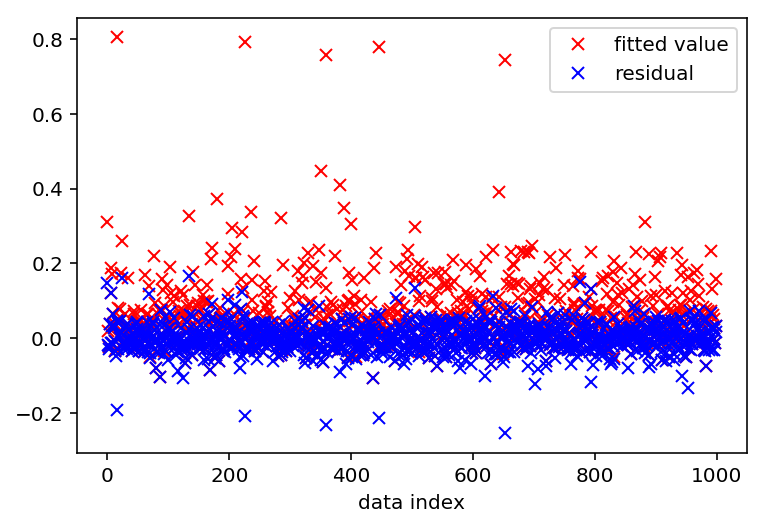

In [134]:
for rd in range(folds):
    clf = MLPRegressor(hidden_layer_sizes=(min_hidden), activation=min_act, solver='lbfgs', max_iter=100,
                       learning_rate_init=0.01, alpha=0.01)
    X_train, X_test, y_train, y_test = train_test_split(standard_data, training_label, train_size=0.9)
    # pipeline = Pipeline([("polynomial_features", polynomial_features), ("Neural_network", clf)])
    pipeline = Pipeline([("Neural_network", clf)])
    pipeline.fit(X_train, y_train)
    train_predict = pipeline.predict(X_train)
    test_predict = pipeline.predict(X_test)
    # clf.fit(onehot_encoded_data, training_label)
    # print standard_data.shape
    # print training_label.shape
    plot_test_all.extend(test_predict)
    plot_gd_all.extend(y_test)
two_plots_revised(plot_test_all, plot_gd_all)

Question 2(d)

In [93]:
df = pd.read_csv('./network_backup_dataset.csv')
df_group = df.groupby([df.columns[0], df.columns[1], df.columns[3]], sort=False).sum().iloc[:,1:2]
# df_group = df_group.reset_index()

In [94]:
sizes = [[],[],[],[],[]]
length=0
for index, row in df_group.iterrows():
    sizes[int(index[2][-1])].append(row[0])

In [95]:
import calendar
days = dict(zip(calendar.day_name,range(1,8)))

df.drop('Backup Time (hour)', axis=1, inplace=True)
df['Day of Week'] = df['Day of Week'].apply(lambda s: days[s])

f = lambda s: int(s[s.rindex('_')+1:])

df['Work-Flow-ID'] = df['Work-Flow-ID'].apply(f)
df['File Name'] = df['File Name'].apply(f)

In [96]:
Xs, ys = [], []
for key, value in df.groupby('Work-Flow-ID').groups.items():
    group = df.loc[value].drop('Work-Flow-ID', axis=1).reset_index(drop=True)
    Xs.append(group.drop('Size of Backup (GB)', axis=1))
    ys.append(group[['Size of Backup (GB)']])

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

def cv_linear(model, X, y):
    kf = KFold(n_splits=10)
    rmse_train, rmse_test = 0, 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        model.fit(X_train, y_train)
        rmse_train += mean_squared_error(y_train, model.predict(X_train))
        rmse_test += mean_squared_error(y_test, model.predict(X_test))

    return sqrt(rmse_train / 10), sqrt(rmse_test / 10)

In [98]:
# Question 2d_i: 
for i in range(len(ys)):
    rmse_train, rmse_test = cv_linear(LinearRegression(), Xs[i], ys[i])
    print("%s: RMSE_train = %f RMSE_test = %f" % ('work_flow_'+str(i), rmse_train, rmse_test))

work_flow_0: RMSE_train = 0.035836 RMSE_test = 0.035887
work_flow_1: RMSE_train = 0.148766 RMSE_test = 0.148919
work_flow_2: RMSE_train = 0.042909 RMSE_test = 0.043067
work_flow_3: RMSE_train = 0.007244 RMSE_test = 0.007261
work_flow_4: RMSE_train = 0.085922 RMSE_test = 0.085991


In [99]:
# Question 2d_ii, High degrees can cause overfitting.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degrees = [2,3,4,5,6,7,8,9]
rmses_train, rmses_test = [], []
for i in range(len(ys)):
    rmses_train.append([])
    rmses_test.append([])
    for degree in degrees:
        model = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression())
        rmse_train, rmse_test = cv_linear(model, Xs[i], ys[i])
        rmses_train[i].append(rmse_train)
        rmses_test[i].append(rmse_test)

In [100]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)
def plot_metric(y, x, metric=''):
    data = []
    
    for i in range(len(y)):
        trace = go.Scatter(x=x, y=y[i], mode='lines', 
                           line=dict(width=2), name=('work_flow_'+str(i)))
        data.append(trace)

    layout = go.Layout(title=metric+' VS Degree',
                       xaxis=dict(title='Degree', dtick=1),
                       yaxis=dict(title=metric))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [101]:
print(degrees)
plot_metric(rmses_train, degrees, 'RMSE_Train')
plot_metric(rmses_test, degrees, 'RMSE_Test')

[2, 3, 4, 5, 6, 7, 8, 9]


In [102]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt

def two_plots(allpre_res, pre_gt):
    x = range(0, 1000)
    y1 = allpre_res 
    y2 = pre_gt  
    residual = [pre_gt_i - allpre_res_i for pre_gt_i, allpre_res_i in zip(pre_gt, allpre_res)]
    y3 = residual

    # show basic model plot
    # fitted value & ground truth
    # only plot the first 1000 data points and results we get.
    # blue 'x' is gt, while red 'x' is fitted value
    fig = plt.figure()  
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y2[0:1000], 'bx', label='ground truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

    # fitted value & residual
    fig = plt.figure()  
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y3[0:1000], 'bx', label='residual')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

In [103]:
X = df.drop('Size of Backup (GB)', axis=1)
y = df[['Size of Backup (GB)']]
model = make_pipeline(PolynomialFeatures(degree=7, include_bias=False), LinearRegression())
kf = KFold(n_splits=10)
predictions, ground_truth = [], []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model.fit(X_train, y_train)
    for num in model.predict(X_test).tolist():
        predictions.extend(num)
    for num in y_test.values.tolist():
        ground_truth.extend(num)

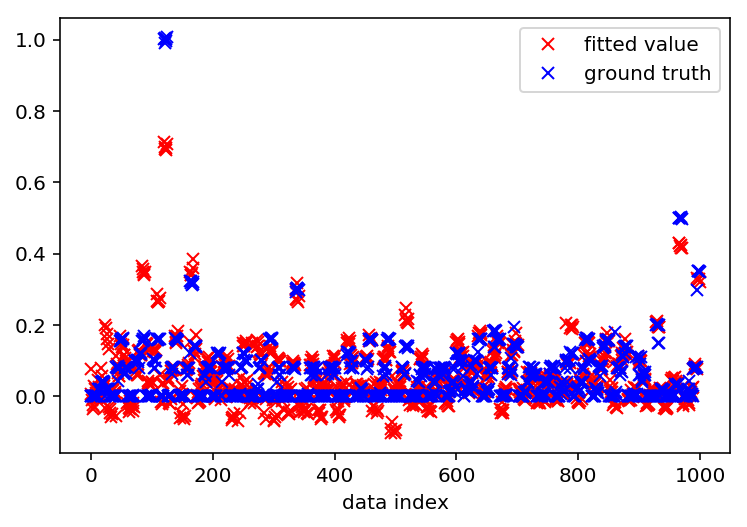

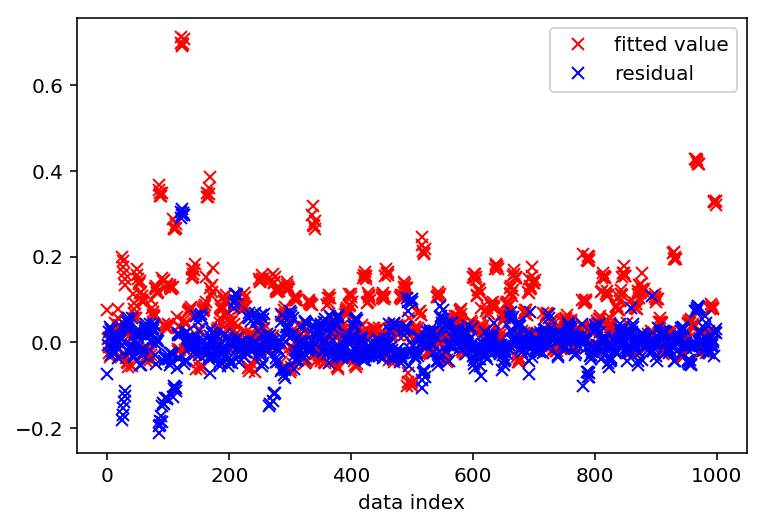

In [104]:
two_plots(predictions, ground_truth)

Question 2(e)

In [79]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# one hot encoding
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
folds=10
rmse_plot_train = []
rmse_plot_test = []
rmse_gd = []
plot_gd_all = []
plot_test_all = []
min_test = 100
min_neigh = 0
for neighborsize in range(1, 100):
    for rd in range(folds):
        # polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
        clf = KNeighborsRegressor(n_neighbors=neighborsize)
        X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, train_size=0.9)
        pipeline = Pipeline([ ("KNN", clf)])
        pipeline.fit(X_train, y_train)
        train_predict = pipeline.predict(X_train)
        test_predict = pipeline.predict(X_test)
        # clf.fit(onehot_encoded_data, training_label)
        # print standard_data.shape
        # print training_label.shape
        rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predict)))
    print ('rmse_train: ', np.mean(rmse_train), 'rmse_test:', np.mean(rmse_test))
    if min_test > np.mean(rmse_test):
        min_test = np.mean(rmse_test)
        min_neigh = neighborsize
    rmse_plot_train.append(np.mean(rmse_train))
    rmse_plot_test.append(np.mean(rmse_test))
    rmse_train = []
    rmse_test = []
print ("min test rmse: ", min_test, "at neighbour size: ", min_neigh)

rmse_train:  0.018395953497860964 rmse_test: 0.061895994437848406
rmse_train:  0.02964644147913671 rmse_test: 0.0429609569810752
rmse_train:  0.029390321261297918 rmse_test: 0.03689983416264968
rmse_train:  0.027993827879178014 rmse_test: 0.035308581099246235
rmse_train:  0.027469757999663547 rmse_test: 0.03505389720056441
rmse_train:  0.02970683407352238 rmse_test: 0.03824456254773458
rmse_train:  0.03328090731956981 rmse_test: 0.04271716505395125
rmse_train:  0.037249305618435535 rmse_test: 0.04251009355462779
rmse_train:  0.03982541799582406 rmse_test: 0.04840877808253201
rmse_train:  0.04179583938765732 rmse_test: 0.048088173515841715
rmse_train:  0.04372205621491336 rmse_test: 0.04941767025659589
rmse_train:  0.045153129052575035 rmse_test: 0.05321103081222519
rmse_train:  0.0465624678953089 rmse_test: 0.05329370653245115
rmse_train:  0.048515321958958274 rmse_test: 0.055060590157674304
rmse_train:  0.050078985477129634 rmse_test: 0.05489521168379978
rmse_train:  0.051241720567488

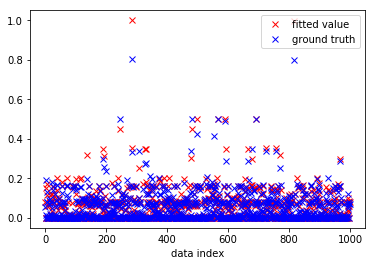

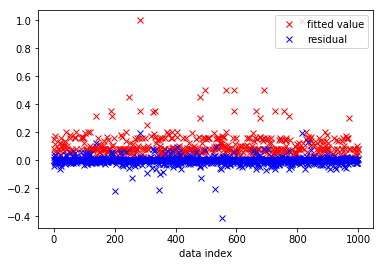

In [80]:
for rd in range(folds):
    # polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
    clf = KNeighborsRegressor(n_neighbors=min_neigh)
    X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, train_size=0.9)
    pipeline = Pipeline([("KNN", clf)])
    pipeline.fit(X_train, y_train)
    train_predict = pipeline.predict(X_train)
    test_predict = pipeline.predict(X_test)
    # clf.fit(onehot_encoded_data, training_label)
    # print standard_data.shape
    # print training_label.shape
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predict)))
    plot_gd_all.extend(test_predict)
    plot_test_all.extend(y_test)

two_plots_revised(plot_test_all, plot_gd_all)

In [90]:
data = []

x_data = np.arange(50, 151)
data.append(go.Scatter(x=x_data, y=rmse_plot_train, mode='lines', line=lineStyle[0],name="Train_"+"KNN"))
data.append(go.Scatter(x=x_data, y=rmse_plot_test, mode='lines', line=lineStyle[1],name="Test_"+"KNN"))

layout = go.Layout(title="Train/Test-RMSE VS number of Neighbors for KNN")

fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename="")